<a href="https://colab.research.google.com/github/Sharath-11507563/Aspect-based-sentimental-analysis-on-Rulemaking-comments/blob/main/Final_project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import nltk, re, string
import pandas as pd
import io
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import seaborn as sn

nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [32]:
url = 'https://raw.githubusercontent.com/Sharath-11507563/Aspect-based-sentimental-analysis-on-Rulemaking-comments/main/Data_with_aspects.csv'
data = pd.read_csv(url)

In [33]:
data.head(5)

,Docket_Id,Comment_Id,Comment,Aspect,Annotator 1,Annotator 2,Annotator 3
0,FDA-2010-D-0277,FDA-2010-D-0277-0007,I am urging the support of FDA 2010-D-0277-000...,children and adolescents,Positive,positive,positive
1,FDA-2010-D-0277,FDA-2010-D-0277-0008,The Family Smoking Prevention and Tobacco Cont...,law,Positive,negative,negative
2,FDA-2010-D-0277,FDA-2010-D-0277-0010,As the director of a state tobacco control pro...,free distribution,Positive,positive,positive
3,FDA-2010-D-0277,FDA-2010-D-0277-0011,"Please, for the protection, health and welfare...",children,Positive,negative,positive
4,FDA-2010-D-0277,FDA-2010-D-0277-0013,"Cigars, little cigars, and pipe tobacco can ho...",young people,Positive,negative,positive


In [34]:
def find_index(comment, aspect):
  aspect_list = aspect.split(",")
  for aspect_ in aspect_list:
    if aspect_.lower() in comment.lower():
      index_ = comment.lower().find(aspect_)
      if index_ == -1: return str(len(comment)-len(aspect_))+"-"+str(len(comment))
      else: return str(index_)+"-"+str(index_+len(aspect_))

In [35]:
stopwords_list = stopwords.words('english') # importing stopwords
punctuations_list = string.punctuation # get punctuations
lemmatizer = WordNetLemmatizer() # initialize word lemmatizer

def filter_annotation(annotator):
  (annotator1, annotator2, annotator3) = annotator
  if annotator1.lower()[:3]=='pos' and annotator2.lower()[:3]=='pos' and annotator3.lower()[:3]=='pos': return "Positive"
  elif annotator1.lower()[:3]=='neg' and annotator2.lower()[:3]=='neg' and annotator3.lower()[:3]=='neg': return "Negative"
  elif annotator1.lower()[:3]=='neu' and annotator2.lower()[:3]=='neu' and annotator3.lower()[:3]=='neu': return "Neutral"
  elif (annotator1.lower()[:3]=='pos' and annotator2.lower()[:3]=='pos') or  (annotator2.lower()[:3]=='pos' and annotator3.lower()[:3]=='pos') or (annotator3.lower()[:3]=='pos' and annotator1.lower()[:3]=='pos'): return "Positive"
  elif (annotator1.lower()[:3]=='neg' and annotator2.lower()[:3]=='neg') or (annotator2.lower()[:3]=='neg' and annotator3.lower()[:3]=='neg') or (annotator3.lower()[:3]=='neg' and annotator1.lower()[:3]=='neg'): return "Negative"
  elif (annotator1.lower()[:3]=='neu' and annotator2.lower()[:3]=='neu') or (annotator2.lower()[:3]=='neu' and annotator3.lower()[:3]=='neu') or (annotator3.lower()[:3]=='neu' and annotator1.lower()[:3]=='neu'): return "Neutral"
  else: return 'Neutral'

def preprocessing(text):
    """
    This function will clean the given text
    """
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower())
    text = text + " ".join(emoticons).replace('-', '')
    tokenize_text = [lemmatizer.lemmatize(word) for word in nltk.tokenize.word_tokenize(text) 
                     if (word not in stopwords_list) and (word not in punctuations_list) and (len(word)>=2) and (word.isalpha())]
    return " ".join(tokenize_text)

In [36]:
data["Comment"] = data["Comment"].apply(str)
data["Clean_Comment"] = data["Comment"].apply(preprocessing)
data["Aspect Index"] = data[['Comment','Aspect']].apply(lambda x: find_index(*x), axis=1)
data.head(5)

,Docket_Id,Comment_Id,Comment,Aspect,Annotator 1,Annotator 2,Annotator 3,Clean_Comment,Aspect Index
0,FDA-2010-D-0277,FDA-2010-D-0277-0007,I am urging the support of FDA 2010-D-0277-000...,children and adolescents,Positive,positive,positive,urging support fda support effort protecting c...,81-105
1,FDA-2010-D-0277,FDA-2010-D-0277-0008,The Family Smoking Prevention and Tobacco Cont...,law,Positive,negative,negative,family smoking prevention tobacco control act ...,92-95
2,FDA-2010-D-0277,FDA-2010-D-0277-0010,As the director of a state tobacco control pro...,free distribution,Positive,positive,positive,director state tobacco control program would s...,158-175
3,FDA-2010-D-0277,FDA-2010-D-0277-0011,"Please, for the protection, health and welfare...",children,Positive,negative,positive,please protection health welfare child free to...,54-62
4,FDA-2010-D-0277,FDA-2010-D-0277-0013,"Cigars, little cigars, and pipe tobacco can ho...",young people,Positive,negative,positive,cigar little cigar pipe tobacco hook young peo...,49-61


In [37]:
annotator = list(zip(data["Annotator 1"], data["Annotator 2"], data["Annotator 3"]))
data["Annotator"] = list(map(filter_annotation, annotator))

In [38]:
def absolute_sentiment(sentiment):
  if sentiment=="Positive": return 1
  elif sentiment=="Negative": return -1
  else: return 0
  
data['Triple_Sentiments'] = data['Annotator'].apply(absolute_sentiment)
data['Single_Sentiments'] = data['Annotator 1'].apply(absolute_sentiment)
data.head(5)

,Docket_Id,Comment_Id,Comment,Aspect,Annotator 1,Annotator 2,Annotator 3,Clean_Comment,Aspect Index,Annotator,Triple_Sentiments,Single_Sentiments
0,FDA-2010-D-0277,FDA-2010-D-0277-0007,I am urging the support of FDA 2010-D-0277-000...,children and adolescents,Positive,positive,positive,urging support fda support effort protecting c...,81-105,Positive,1,1
1,FDA-2010-D-0277,FDA-2010-D-0277-0008,The Family Smoking Prevention and Tobacco Cont...,law,Positive,negative,negative,family smoking prevention tobacco control act ...,92-95,Negative,-1,1
2,FDA-2010-D-0277,FDA-2010-D-0277-0010,As the director of a state tobacco control pro...,free distribution,Positive,positive,positive,director state tobacco control program would s...,158-175,Positive,1,1
3,FDA-2010-D-0277,FDA-2010-D-0277-0011,"Please, for the protection, health and welfare...",children,Positive,negative,positive,please protection health welfare child free to...,54-62,Positive,1,1
4,FDA-2010-D-0277,FDA-2010-D-0277-0013,"Cigars, little cigars, and pipe tobacco can ho...",young people,Positive,negative,positive,cigar little cigar pipe tobacco hook young peo...,49-61,Positive,1,1


In [39]:
data['Number of Sentences'] = data['Comment'].apply(lambda x: len(str(x).split(".")))
data['Number of Words'] = data['Comment'].apply(lambda x: len(str(x).split(" ")))
data['Number of Characters'] = data['Comment'].str.len()
def avg_word_length(sentence):
  words = sentence.split()
  if len(words) != 0:
    return(sum(len(word) for word in words)/len(words))
  else:
    return None
data['Average Word Length'] = data['Comment'].apply(lambda x: avg_word_length(x))
stop = stopwords.words('english')
data['Number of Stopwords'] = data['Comment'].apply(lambda x: len([x for x in x.split() if x in stop]))
data['Number of numerics'] = data['Comment'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
data['Number of upper case words'] = data['Comment'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
data.head(5)

,Docket_Id,Comment_Id,Comment,Aspect,Annotator 1,Annotator 2,Annotator 3,Clean_Comment,Aspect Index,Annotator,Triple_Sentiments,Single_Sentiments,Number of Sentences,Number of Words,Number of Characters,Average Word Length,Number of Stopwords,Number of numerics,Number of upper case words
0,FDA-2010-D-0277,FDA-2010-D-0277-0007,I am urging the support of FDA 2010-D-0277-000...,children and adolescents,Positive,positive,positive,urging support fda support effort protecting c...,81-105,Positive,1,1,5,75,459,5.133333,32,0,4
1,FDA-2010-D-0277,FDA-2010-D-0277-0008,The Family Smoking Prevention and Tobacco Cont...,law,Positive,negative,negative,family smoking prevention tobacco control act ...,92-95,Negative,-1,1,6,142,908,5.401408,46,3,3
2,FDA-2010-D-0277,FDA-2010-D-0277-0010,As the director of a state tobacco control pro...,free distribution,Positive,positive,positive,director state tobacco control program would s...,158-175,Positive,1,1,4,75,495,5.613333,25,0,1
3,FDA-2010-D-0277,FDA-2010-D-0277-0011,"Please, for the protection, health and welfare...",children,Positive,negative,positive,please protection health welfare child free to...,54-62,Positive,1,1,4,61,359,4.901639,23,0,2
4,FDA-2010-D-0277,FDA-2010-D-0277-0013,"Cigars, little cigars, and pipe tobacco can ho...",young people,Positive,negative,positive,cigar little cigar pipe tobacco hook young peo...,49-61,Positive,1,1,3,26,178,5.884615,10,0,1


In [40]:
print('The maximum,mimimum and average Number of sentences are',data['Number of Sentences'].max(),',',data['Number of Sentences'].min(),',',data['Number of Sentences'].mean())
print('The maximum,minimum and average Number of Words are',data['Number of Words'].max(),',',data['Number of Words'].min(),',',data['Number of Words'].mean())
print('The maximum,mimimum and average Number of Characters are',data['Number of Characters'].max(),',',data['Number of Characters'].min(),',',data['Number of Characters'].mean())
print('The maximum,mimimum and average of Average Word Length are',data['Average Word Length'].max(),',',data['Average Word Length'].min(),',',data['Average Word Length'].mean())
print('The maximum,mimimum and average Number of Stopwords are',data['Number of Stopwords'].max(),',',data['Number of Stopwords'].min(),',',data['Number of Stopwords'].mean())
print('The maximum,mimimum and average Number of numerics are',data['Number of numerics'].max(),',',data['Number of numerics'].min(),',',data['Number of numerics'].mean())
print('The maximum,mimimum and average Number of upper case words are',data['Number of upper case words'].max(),',',data['Number of upper case words'].min(),',',data['Number of upper case words'].mean())

The maximum,mimimum and average Number of sentences are 111 , 1 , 9.435871743486974
The maximum,minimum and average Number of Words are 899 , 3 , 148.84068136272546
The maximum,mimimum and average Number of Characters are 5042 , 13 , 904.5821643286573
The maximum,mimimum and average of Average Word Length are 14.2 , 2.5 , 5.012063117688139
The maximum,mimimum and average Number of Stopwords are 386 , 0 , 58.90480961923848
The maximum,mimimum and average Number of numerics are 11 , 0 , 0.6863727454909819
The maximum,mimimum and average Number of upper case words are 226 , 0 , 5.214428857715431


#Triple annotation models

In [41]:
comment = data["Aspect"]
sentiment = data["Triple_Sentiments"]

In [42]:
X_train, X_test, Y_train, Y_test = train_test_split(comment,sentiment, test_size = 0.3, random_state = 60,shuffle=True, stratify=sentiment)

Accuracy:  0.53
Navie Bayes accuracy on train data:  79 %
Navie Bayes accuracy on test data:  53 %
              precision    recall  f1-score   support

          -1       0.80      0.61      0.69       180
           0       0.14      0.29      0.19        34
           1       0.44      0.45      0.45        86

    accuracy                           0.53       300
   macro avg       0.46      0.45      0.44       300
weighted avg       0.62      0.53      0.57       300

The Average Accuracy score for a ten-fold cross-validations is: 0.493989898989899


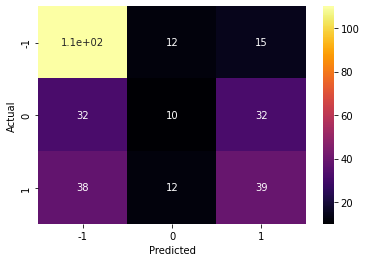

In [43]:
nb_pipeline = Pipeline([('tfidf', TfidfVectorizer()), ('model', MultinomialNB()),])
nb_pipeline.fit(X_train,Y_train)

Y_pred = nb_pipeline.predict(X_test)

confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='inferno')
print('Accuracy: ',metrics.accuracy_score(Y_test, Y_pred))
print("Navie Bayes accuracy on train data: ", round(nb_pipeline.score(X_train,Y_train)*100), '%')
print("Navie Bayes accuracy on test data: ", round(nb_pipeline.score(X_test,Y_test)*100), '%')
print(classification_report(Y_pred, Y_test))
print('The Average Accuracy score for a ten-fold cross-validations is:',cross_val_score(nb_pipeline, comment, sentiment, cv=10, scoring ='accuracy').mean())

SVM accuracy on train data:  82 %
SVM accuracy on test data:  54 %
              precision    recall  f1-score   support

          -1       0.79      0.63      0.70       172
           0       0.19      0.34      0.24        41
           1       0.44      0.45      0.44        87

    accuracy                           0.54       300
   macro avg       0.47      0.47      0.46       300
weighted avg       0.60      0.54      0.56       300

The Average Accuracy score for a ten-fold cross-validations is: 0.47194949494949495


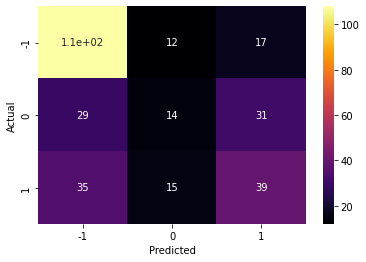

In [44]:
svm_pipeline = Pipeline([('tfidf', TfidfVectorizer()),('model', SGDClassifier()),])
svm_pipeline.fit(X_train,Y_train)

Y_pred = svm_pipeline.predict(X_test)

confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='inferno')
print("SVM accuracy on train data: ", round(svm_pipeline.score(X_train,Y_train)*100), '%')
print("SVM accuracy on test data: ", round(svm_pipeline.score(X_test,Y_test)*100), '%')
print(classification_report(Y_pred, Y_test))
print('The Average Accuracy score for a ten-fold cross-validations is:',cross_val_score(svm_pipeline, comment, sentiment, cv=10, scoring ='accuracy').mean())

Decision Tree accuracy on train data:  85 %
Decision Tree accuracy on test data:  55 %
              precision    recall  f1-score   support

          -1       0.84      0.62      0.71       186
           0       0.31      0.40      0.35        57
           1       0.31      0.49      0.38        57

    accuracy                           0.55       300
   macro avg       0.49      0.50      0.48       300
weighted avg       0.64      0.55      0.58       300

The Average Accuracy score for a ten-fold cross-validations is: 0.48096969696969694


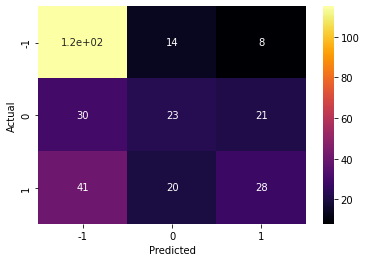

In [45]:
DT_pipeline = Pipeline([('tfidf', TfidfVectorizer()),('model', DecisionTreeClassifier()),])
DT_pipeline.fit(X_train,Y_train)

Y_pred = DT_pipeline.predict(X_test)

confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='inferno')
print("Decision Tree accuracy on train data: ", round(DT_pipeline.score(X_train,Y_train)*100), '%')
print("Decision Tree accuracy on test data: ", round(DT_pipeline.score(X_test,Y_test)*100), '%')
print(classification_report(Y_pred, Y_test))
print('The Average Accuracy score for a ten-fold cross-validations is:',cross_val_score(DT_pipeline, comment, sentiment, cv=10, scoring ='accuracy').mean())

Random Forest accuracy on train data:  85 %
Random Forest accuracy on test data:  56 %
              precision    recall  f1-score   support

          -1       0.85      0.62      0.72       189
           0       0.23      0.39      0.29        44
           1       0.37      0.49      0.42        67

    accuracy                           0.56       300
   macro avg       0.48      0.50      0.48       300
weighted avg       0.65      0.56      0.59       300

The Average Accuracy score for a ten-fold cross-validations is: 0.4819494949494949


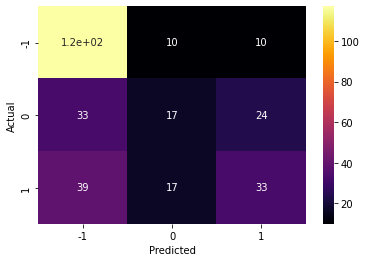

In [46]:
RF_pipeline = Pipeline([('tfidf', TfidfVectorizer()),('model', RandomForestClassifier()),])
RF_pipeline.fit(X_train,Y_train)

Y_pred = RF_pipeline.predict(X_test)

confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='inferno')
print("Random Forest accuracy on train data: ", round(RF_pipeline.score(X_train,Y_train)*100), '%')
print("Random Forest accuracy on test data: ", round(RF_pipeline.score(X_test,Y_test)*100), '%')
print(classification_report(Y_pred, Y_test))
print('The Average Accuracy score for a ten-fold cross-validations is:',cross_val_score(RF_pipeline, comment, sentiment, cv=10, scoring ='accuracy').mean())

Logestic Regression accuracy on train data:  79 %
Logestic Regression accuracy on test data:  54 %
              precision    recall  f1-score   support

          -1       0.82      0.60      0.69       188
           0       0.19      0.34      0.24        41
           1       0.39      0.49      0.44        71

    accuracy                           0.54       300
   macro avg       0.47      0.48      0.46       300
weighted avg       0.63      0.54      0.57       300

The Average Accuracy score for a ten-fold cross-validations is: 0.490010101010101


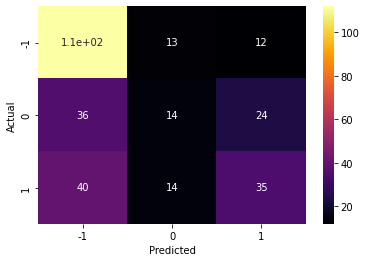

In [47]:
LR_pipeline = Pipeline([('tfidf', TfidfVectorizer()),('model', LogisticRegression()),])
LR_pipeline.fit(X_train,Y_train)

Y_pred = LR_pipeline.predict(X_test)

confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='inferno')
print("Logestic Regression accuracy on train data: ", round(LR_pipeline.score(X_train,Y_train)*100), '%')
print("Logestic Regression accuracy on test data: ", round(LR_pipeline.score(X_test,Y_test)*100), '%')
print(classification_report(Y_pred, Y_test))
print('The Average Accuracy score for a ten-fold cross-validations is:',cross_val_score(LR_pipeline, comment, sentiment, cv=10, scoring ='accuracy').mean())

#Single annotation models

In [48]:
comment = data["Clean_Comment"]
sentiment = data["Single_Sentiments"]

In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(comment,sentiment, test_size = 0.3, random_state = 60,shuffle=True,stratify=sentiment)

Navie Bayes accuracy on train data:  76 %
Navie Bayes accuracy on test data:  56 %
              precision    recall  f1-score   support

          -1       0.89      0.58      0.70       217
           0       0.26      0.62      0.37        34
           1       0.29      0.47      0.36        49

    accuracy                           0.56       300
   macro avg       0.48      0.55      0.47       300
weighted avg       0.72      0.56      0.61       300

The Average Accuracy score for a ten-fold cross-validations is: 0.5231919191919192


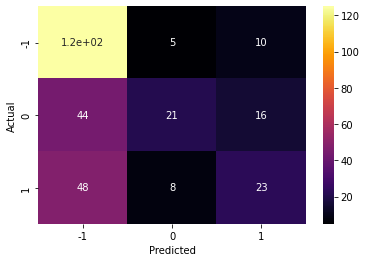

In [50]:
nb_pipeline = Pipeline([('tfidf', TfidfVectorizer()), ('model', MultinomialNB()),])
nb_pipeline.fit(X_train,Y_train)

Y_pred = nb_pipeline.predict(X_test)

confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='inferno')
print("Navie Bayes accuracy on train data: ", round(nb_pipeline.score(X_train,Y_train)*100), '%')
print("Navie Bayes accuracy on test data: ", round(nb_pipeline.score(X_test,Y_test)*100), '%')
print(classification_report(Y_pred, Y_test))
print('The Average Accuracy score for a ten-fold cross-validations is:',cross_val_score(nb_pipeline, comment, sentiment, cv=10, scoring ='accuracy').mean())

SVM accuracy on train data:  98 %
SVM accuracy on test data:  63 %
              precision    recall  f1-score   support

          -1       0.72      0.75      0.74       134
           0       0.49      0.56      0.52        72
           1       0.61      0.51      0.55        94

    accuracy                           0.63       300
   macro avg       0.61      0.61      0.61       300
weighted avg       0.63      0.63      0.63       300

The Average Accuracy score for a ten-fold cross-validations is: 0.5492525252525252


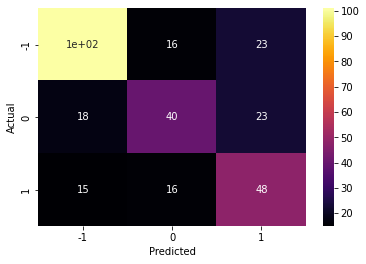

In [51]:
svm_pipeline = Pipeline([('tfidf', TfidfVectorizer()),('model', SGDClassifier()),])
svm_pipeline.fit(X_train,Y_train)

Y_pred = svm_pipeline.predict(X_test)

confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='inferno')
print("SVM accuracy on train data: ", round(svm_pipeline.score(X_train,Y_train)*100), '%')
print("SVM accuracy on test data: ", round(svm_pipeline.score(X_test,Y_test)*100), '%')
print(classification_report(Y_pred, Y_test))
print('The Average Accuracy score for a ten-fold cross-validations is:',cross_val_score(svm_pipeline, comment, sentiment, cv=10, scoring ='accuracy').mean())

Decision Tree accuracy on train data:  100 %
Decision Tree accuracy on test data:  57 %
              precision    recall  f1-score   support

          -1       0.69      0.72      0.70       133
           0       0.48      0.44      0.46        88
           1       0.47      0.47      0.47        79

    accuracy                           0.57       300
   macro avg       0.55      0.54      0.54       300
weighted avg       0.57      0.57      0.57       300

The Average Accuracy score for a ten-fold cross-validations is: 0.5462424242424242


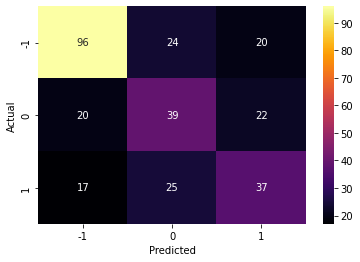

In [52]:
DT_pipeline = Pipeline([('tfidf', TfidfVectorizer()),('model', DecisionTreeClassifier()),])
DT_pipeline.fit(X_train,Y_train)

Y_pred = DT_pipeline.predict(X_test)

confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='inferno')
print("Decision Tree accuracy on train data: ", round(DT_pipeline.score(X_train,Y_train)*100), '%')
print("Decision Tree accuracy on test data: ", round(DT_pipeline.score(X_test,Y_test)*100), '%')
print(classification_report(Y_pred, Y_test))
print('The Average Accuracy score for a ten-fold cross-validations is:',cross_val_score(DT_pipeline, comment, sentiment, cv=10, scoring ='accuracy').mean())

Random Forest accuracy on train data:  100 %
Random Forest accuracy on test data:  60 %
              precision    recall  f1-score   support

          -1       0.81      0.68      0.74       167
           0       0.42      0.60      0.49        57
           1       0.43      0.45      0.44        76

    accuracy                           0.60       300
   macro avg       0.55      0.57      0.56       300
weighted avg       0.64      0.60      0.61       300

The Average Accuracy score for a ten-fold cross-validations is: 0.6013131313131312


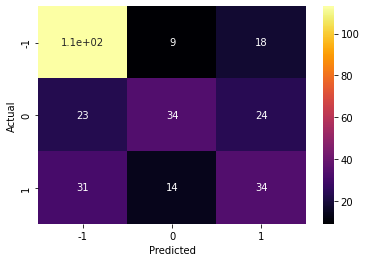

In [53]:
RF_pipeline = Pipeline([('tfidf', TfidfVectorizer()),('model', RandomForestClassifier()),])
RF_pipeline.fit(X_train,Y_train)

Y_pred = RF_pipeline.predict(X_test)

confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='inferno')
print("Random Forest accuracy on train data: ", round(RF_pipeline.score(X_train,Y_train)*100), '%')
print("Random Forest accuracy on test data: ", round(RF_pipeline.score(X_test,Y_test)*100), '%')
print(classification_report(Y_pred, Y_test))
print('The Average Accuracy score for a ten-fold cross-validations is:',cross_val_score(RF_pipeline, comment, sentiment, cv=10, scoring ='accuracy').mean())

Logestic Regression accuracy on train data:  91 %
Logestic Regression accuracy on test data:  62 %
              precision    recall  f1-score   support

          -1       0.80      0.70      0.75       160
           0       0.44      0.59      0.51        61
           1       0.47      0.47      0.47        79

    accuracy                           0.62       300
   macro avg       0.57      0.59      0.57       300
weighted avg       0.64      0.62      0.62       300

The Average Accuracy score for a ten-fold cross-validations is: 0.5982828282828283


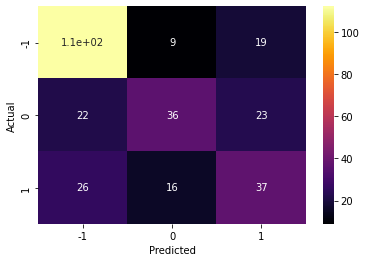

In [54]:
LR_pipeline = Pipeline([('tfidf', TfidfVectorizer()),('model', LogisticRegression()),])
LR_pipeline.fit(X_train,Y_train)

Y_pred = LR_pipeline.predict(X_test)

confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='inferno')
print("Logestic Regression accuracy on train data: ", round(LR_pipeline.score(X_train,Y_train)*100), '%')
print("Logestic Regression accuracy on test data: ", round(LR_pipeline.score(X_test,Y_test)*100), '%')
print(classification_report(Y_pred, Y_test))
print('The Average Accuracy score for a ten-fold cross-validations is:',cross_val_score(LR_pipeline, comment, sentiment, cv=10, scoring ='accuracy').mean())